In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

#Load Data
train_data = pd.read_csv('../DATA/data.csv')


In [9]:
train_data.head()

,ArticleId,Text,Category
0,14,One man's claims that he scammed people on the...,TECH
1,18,Maury Wills who helped the Los Angeles Dodgers...,SPORTS
2,21,For the past 18 months Hollywood has effective...,ENTERTAINMENT
3,22,President issues vow as tensions with China rise.,POLITICS
4,25,An annual celebration took on a different feel...,POLITICS


In [10]:
# Basic Data Exploration
print("NUMBER OF DATA POINTS -",train_data.shape[0])
print("NUMBER OF FEATURES -",train_data.shape[1])
print("FEATURES -",train_data.columns.values)

NUMBER OF DATA POINTS - 64351
NUMBER OF FEATURES - 3
FEATURES - ['ArticleId' 'Text' 'Category']


In [11]:
# Data Points per Category
train_data['Category'].value_counts()

POLITICS         34696
ENTERTAINMENT    16953
BUSINESS          5753
SPORTS            4933
TECH              1958
Name: Category, dtype: int64

In [12]:
# Data Cleaning. Removing rows with missing values
train_data.dropna(inplace=True)
train_data.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [13]:
target_category = train_data['Category'].unique()
print(target_category)

['TECH' 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'BUSINESS']


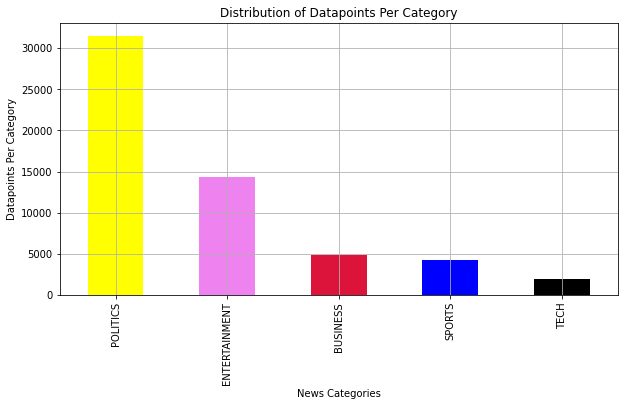

In [14]:
# Plotting data points per category
news_cat = train_data['Category'].value_counts()

plt.figure(figsize=(10,5))
my_colors = ['yellow','violet','crimson','blue','black']
news_cat.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("News Categories")
plt.ylabel("Datapoints Per Category")
plt.title("Distribution of Datapoints Per Category")
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

In [16]:
import warnings
warnings.filterwarnings("ignore")
import re

# Loading stopwords from nltk library
stop_words = set(stopwords.words('english'))
# Function for text preprocessing
def txt_preprocessing(total_text, index, column, df):
    if type(total_text) is not int:
        string = ""
        # Replace every special character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # Remove multiple spaces
        total_text = re.sub('\s+',' ', total_text)
        # Converting to lowercase
        total_text = total_text.lower()
        
        for word in total_text.split():
        # If word is not a stopword then retain that word from the data
            if not word in stop_words:
                string += word + " "
        df[column][index] = string

In [17]:
# Preprocessing the data

for index, row in train_data.iterrows():
    if type(row['Text']) is str:
        txt_preprocessing(row['Text'], index, 'Text', train_data)

train_data.head()

,ArticleId,Text,Category
0,14,one man claims scammed people platform caused ...,TECH
1,18,maury wills helped los angeles dodgers win thr...,SPORTS
2,21,past 18 months hollywood effectively boycotted...,ENTERTAINMENT
3,22,president issues vow tensions china rise,POLITICS
4,25,annual celebration took different feel russia ...,POLITICS


In [18]:
# Dividing the data into train and test set
from sklearn.model_selection import train_test_split
X_train = train_data
y_train = train_data['Category']

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=0)

print("NUMBER OF DATA POINTS IN TRAIN DATA :", X_train.shape[0])
print("NUMBER OF DATA POINTS IN CROSS VALIDATION DATA :", X_cv.shape[0])

NUMBER OF DATA POINTS IN TRAIN DATA : 45578
NUMBER OF DATA POINTS IN CROSS VALIDATION DATA : 11395


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

text_vectorizer = CountVectorizer()
train_text_ohe = text_vectorizer.fit_transform(X_train['Text'])

train_text_features = text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_ohe.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total Number of Unique Words in Train Data :",len(train_text_features))

Total Number of Unique Words in Train Data : 36756


In [ ]:
print(text_fea_dict)

In [21]:
from sklearn.preprocessing import normalize

train_text_ohe = normalize(train_text_ohe, axis=0)
cv_text_ohe = text_vectorizer.transform(X_cv['Text'])
cv_text_ohe = normalize(cv_text_ohe, axis=0)

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]

cv_log_error_array = []

for i in alpha:
    # print("For Alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_text_ohe, y_train)
    
    nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    nb_sig_clf.fit(train_text_ohe, y_train)
    
    sig_clf_probs = nb_sig_clf.predict_proba(cv_text_ohe)
    
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))

best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_text_ohe, y_train)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_ohe, y_train)

predict_y = nb_sig_clf.predict_proba(train_text_ohe)
print('For values of best alpha =', alpha[best_alpha],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = nb_sig_clf.predict_proba(cv_text_ohe)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha = 0.1 The train log loss is: 0.5850322986639813
For values of best alpha = 0.1 The cross validation log loss is: 0.8255694466806821


In [23]:
from sklearn.metrics import accuracy_score
predicted_y = nb_sig_clf.predict(cv_text_ohe)
train_accuracy = (nb_sig_clf.score(train_text_ohe, y_train)*100)
cv_accuracy = (accuracy_score(predicted_y, y_cv)*100)

print("Naive Bayes Train Accuracy -",train_accuracy)
print("Naive Bayes CV Accuracy -",cv_accuracy)

Naive Bayes Train Accuracy - 81.97814735179253
Naive Bayes CV Accuracy - 70.68889863975429
